In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid', font='monospace')

In [2]:
df = pd.read_csv('data_wo_outliers.csv', index_col=0)

In [3]:
df.drop(columns=['name'], inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1031 entries, 0 to 1556
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   wins            1031 non-null   int64  
 1   kills           1031 non-null   int64  
 2   kdRatio         1031 non-null   float64
 3   killstreak      1031 non-null   int64  
 4   level           1031 non-null   int64  
 5   losses          1031 non-null   int64  
 6   prestige        1031 non-null   int64  
 7   hits            1031 non-null   int64  
 8   timePlayed      1031 non-null   int64  
 9   headshots       1031 non-null   int64  
 10  averageTime     1031 non-null   float64
 11  gamesPlayed     1031 non-null   int64  
 12  assists         1031 non-null   int64  
 13  misses          1031 non-null   int64  
 14  xp              1031 non-null   int64  
 15  scorePerMinute  1031 non-null   float64
 16  shots           1031 non-null   int64  
 17  deaths          1031 non-null   int64 

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

## Regression (w/ Principal Componenet Analysis)

---

> Under **`regression.ipynb`**, we have analysed the performance of the regression models using all $9$ columns. That's *nine*
> dimensions with just slightly more than a thousand data points. The resulting matrix containing our data points is likely to be
> sparse and could hurt the training process. We'll attempt to reduce the dimensionality to just three dimensions using a technique
> known as **Principal Component Analysis** (PCA) and see if it improves the regression results.

In [6]:
def model_evaluation(df, predictors, target, model_instance):
    df_train, df_test = train_test_split(df, test_size=0.2)

    pipeline = Pipeline([
        ('Standardization', StandardScaler()),
        ('PCA', PCA(n_components=3)),
        ('Regression', model_instance),
    ])
    
    model = pipeline.fit(df_train[predictors], df_train[[target]])

    print('<<- Principal Component Analysis (Explained Variance) ->>\n')
    print(f'Component 1: {model["PCA"].explained_variance_ratio_[0]*100:.2f}%')
    print(f'Component 2: {model["PCA"].explained_variance_ratio_[1]*100:.2f}%')
    print(f'Component 3: {model["PCA"].explained_variance_ratio_[2]*100:.2f}%')
    print()
    
    pred_train, pred_test = model.predict(df_train[predictors]), model.predict(df_test[predictors])
    r2_train, mse_test = r2_score(df_train[[target]], pred_train), mean_squared_error(df_test[[target]], pred_test)

    print('<<- Regression Results ->>\n')
    print(f'r2 (Train Set)\t{r2_train:.3f}')
    print(f'MSE (Test Set)\t{mse_test:.3f}')

    return r2_train, mse_test

In [7]:
def model_evaluation_w_grid_search(df, predictors, target, model_instance, param_grid, cv):
    df_train, df_test = train_test_split(df, test_size=0.2)
    
    pipeline = Pipeline([
        ('Standardization', StandardScaler()),
        ('PCA', PCA(n_components=3)),
        ('Regression', model_instance),
    ])
    
    model = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='r2')
    model.fit(df_train[predictors], df_train[[target]])

    print('<<- Principal Component Analysis (Explained Variance) ->>\n')
    print(f'Component 1: {model.best_estimator_["PCA"].explained_variance_ratio_[0]*100:.2f}%')
    print(f'Component 2: {model.best_estimator_["PCA"].explained_variance_ratio_[1]*100:.2f}%')
    print(f'Component 3: {model.best_estimator_["PCA"].explained_variance_ratio_[2]*100:.2f}%')
    print()
    
    print('<<- Grid Search Results (Best Parameters) ->>\n')
    for k, v in model.best_params_.items():
       print(f'{k[12:]:10}\t{v}')
    print()
    
    pred_train, pred_test = model.predict(df_train[predictors]), model.predict(df_test[predictors])
    r2_train, mse_test = r2_score(df_train[[target]], pred_train), mean_squared_error(df_test[[target]], pred_test)

    print('<<- Regression Results ->>\n')
    print(f'r2 (Train Set)\t{r2_train:.3f}')
    print(f'MSE (Test Set)\t{mse_test:.3f}')

    return r2_train, mse_test

In [8]:
model_performance = {'kdRatioAlt': {}, 'winRateAlt': {}}

### **Target Variable**: `kdRatioAlt`

In [9]:
predictors = [
    'level',
    'prestige',
    'xp', 
    'hitRate',
    'timePlayed',
    'averageTime',
    'gamesPlayed',
    'headshotRate',
    'assistsPerGame'
]
target = 'kdRatioAlt'

In [10]:
_, mse = model_evaluation(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=LinearRegression(),
)

model_performance[target]['LinearRegression'] = mse

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 59.93%
Component 2: 13.61%
Component 3: 12.27%

<<- Regression Results ->>

r2 (Train Set)	0.863
MSE (Test Set)	0.597


In [11]:
param_grid = {
    'Regression__alpha':    [0.1, 1, 10, 100],
    'Regression__tol':      [1e-3, 1e-4, 1e-5, 1e-6],
    'Regression__max_iter': [1_000, 10_000, 100_000]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=Lasso(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['Lasso'] = mse

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 60.14%
Component 2: 13.51%
Component 3: 12.22%

<<- Grid Search Results (Best Parameters) ->>

alpha     	0.1
max_iter  	1000
tol       	0.0001

<<- Regression Results ->>

r2 (Train Set)	0.851
MSE (Test Set)	0.521


In [12]:
param_grid = {
    'Regression__C':        [1.0, 2.0, 3.0, 4.0, 5.0],
    'Regression__tol':      [1e-3, 1e-4, 1e-5],
    'Regression__max_iter': [-1, 1_000, 10_000, 100_000]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=SVR(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['SVR'] = mse

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 60.45%
Component 2: 13.46%
Component 3: 12.16%

<<- Grid Search Results (Best Parameters) ->>

C         	5.0
max_iter  	10000
tol       	0.001

<<- Regression Results ->>

r2 (Train Set)	0.943
MSE (Test Set)	0.342


In [13]:
param_grid = {
    'Regression__n_neighbors': [5, 10, 15, 20, 25],
    'Regression__leaf_size':   [5, 15, 30, 45],
    'Regression__weights':     ['uniform', 'distance']
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=KNeighborsRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['KNeighborsRegressor'] = mse

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 59.87%
Component 2: 13.80%
Component 3: 12.20%

<<- Grid Search Results (Best Parameters) ->>

leaf_size 	5
n_neighbors	20
weights   	distance

<<- Regression Results ->>

r2 (Train Set)	1.000
MSE (Test Set)	0.372


In [14]:
param_grid = {
    'Regression__n_estimators': [50, 100, 150],
    'Regression__max_depth':    [None, 5, 10],
    'Regression__max_features': [1, 'sqrt', 'log2']
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=RandomForestRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['RandomForestRegressor'] = mse

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 59.89%
Component 2: 13.75%
Component 3: 12.09%

<<- Grid Search Results (Best Parameters) ->>

max_depth 	10
max_features	log2
n_estimators	100

<<- Regression Results ->>

r2 (Train Set)	0.980
MSE (Test Set)	0.318


In [15]:
param_grid = {
    'Regression__learning_rate': [0.1, 1, 10],
    'Regression__n_estimators':  [100, 200],
    'Regression__max_depth':     [3, 5, 7]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=GradientBoostingRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['GradientBoostingRegressor'] = mse

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 59.88%
Component 2: 13.49%
Component 3: 12.34%

<<- Grid Search Results (Best Parameters) ->>

learning_rate	0.1
max_depth 	5
n_estimators	100

<<- Regression Results ->>

r2 (Train Set)	0.993
MSE (Test Set)	0.354


(0.0, 0.7760117406813823)

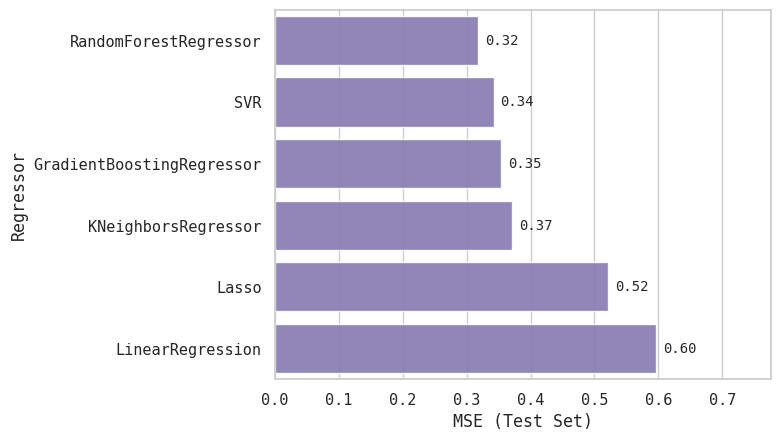

In [16]:
pairs = sorted((v, k) for k, v in model_performance[target].items())
result = {'Regressor': [pair[1] for pair in pairs], 'MSE (Test Set)': [pair[0] for pair in pairs]}
ax = sns.barplot(data=pd.DataFrame(result),
                 x='MSE (Test Set)',
                 y='Regressor',
                 orient='y',
                 color='#8070ba',
                 alpha=0.9)
ax.bar_label(ax.containers[0], fontsize=10, padding=5, fmt='%.2f')
ax.set_xlim(0, result['MSE (Test Set)'][-1] * 1.3)

### **Target Variable**: `winRateAlt`

In [17]:
predictors = [
    'level',
    'prestige',
    'xp', 
    'hitRate',
    'timePlayed',
    'averageTime',
    'gamesPlayed',
    'headshotRate',
    'assistsPerGame'
]
target = 'winRateAlt'

In [18]:
_, mse = model_evaluation(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=LinearRegression(),
)

model_performance[target]['LinearRegression'] = mse

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 59.41%
Component 2: 13.73%
Component 3: 12.39%

<<- Regression Results ->>

r2 (Train Set)	0.878
MSE (Test Set)	0.511


In [19]:
param_grid = {
    'Regression__alpha':    [0.1, 1, 10, 100],
    'Regression__tol':      [1e-3, 1e-4, 1e-5, 1e-6],
    'Regression__max_iter': [1_000, 10_000, 100_000]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=Lasso(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['Lasso'] = mse

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 59.79%
Component 2: 13.44%
Component 3: 12.24%

<<- Grid Search Results (Best Parameters) ->>

alpha     	0.1
max_iter  	1000
tol       	0.001

<<- Regression Results ->>

r2 (Train Set)	0.865
MSE (Test Set)	0.446


In [20]:
param_grid = {
    'Regression__C':        [1.0, 2.0, 3.0, 4.0, 5.0],
    'Regression__tol':      [1e-3, 1e-4, 1e-5],
    'Regression__max_iter': [-1, 1_000, 10_000, 100_000]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=SVR(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['SVR'] = mse

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 59.87%
Component 2: 13.49%
Component 3: 12.74%

<<- Grid Search Results (Best Parameters) ->>

C         	5.0
max_iter  	1000
tol       	0.001

<<- Regression Results ->>

r2 (Train Set)	0.981
MSE (Test Set)	0.092


In [21]:
param_grid = {
    'Regression__n_neighbors': [5, 10, 15, 20, 25],
    'Regression__leaf_size':   [5, 15, 30, 45],
    'Regression__weights':     ['uniform', 'distance']
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=KNeighborsRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['KNeighborsRegressor'] = mse

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 60.38%
Component 2: 13.71%
Component 3: 12.09%

<<- Grid Search Results (Best Parameters) ->>

leaf_size 	5
n_neighbors	5
weights   	distance

<<- Regression Results ->>

r2 (Train Set)	1.000
MSE (Test Set)	0.112


In [22]:
param_grid = {
    'Regression__n_estimators': [50, 100, 150],
    'Regression__max_depth':    [None, 5, 10],
    'Regression__max_features': [1, 'sqrt', 'log2']
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=RandomForestRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['RandomForestRegressor'] = mse

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 59.36%
Component 2: 13.75%
Component 3: 12.60%

<<- Grid Search Results (Best Parameters) ->>

max_depth 	None
max_features	sqrt
n_estimators	50

<<- Regression Results ->>

r2 (Train Set)	0.994
MSE (Test Set)	0.134


In [23]:
param_grid = {
    'Regression__learning_rate': [0.1, 1, 10],
    'Regression__n_estimators':  [100, 200],
    'Regression__max_depth':     [3, 5, 7]
}

_, mse = model_evaluation_w_grid_search(
    df=df,
    predictors=predictors,
    target=target,
    model_instance=GradientBoostingRegressor(),
    param_grid=param_grid,
    cv=3
)

model_performance[target]['GradientBoostingRegressor'] = mse

<<- Principal Component Analysis (Explained Variance) ->>

Component 1: 60.57%
Component 2: 13.52%
Component 3: 12.08%

<<- Grid Search Results (Best Parameters) ->>

learning_rate	0.1
max_depth 	5
n_estimators	100

<<- Regression Results ->>

r2 (Train Set)	0.999
MSE (Test Set)	0.107


(0.0, 0.6640982267133896)

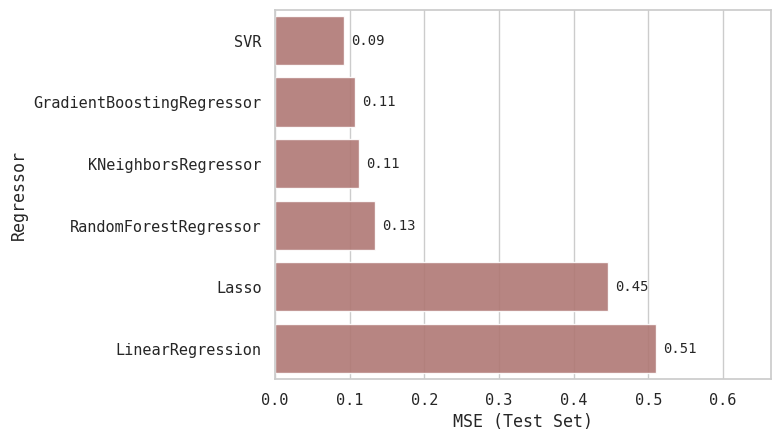

In [24]:
pairs = sorted((v, k) for k, v in model_performance[target].items())
result = {'Regressor': [pair[1] for pair in pairs], 'MSE (Test Set)': [pair[0] for pair in pairs]}
ax = sns.barplot(data=pd.DataFrame(result),
                 x='MSE (Test Set)',
                 y='Regressor',
                 orient='y',
                 color='#ba706a',
                 alpha=0.9)
ax.bar_label(ax.containers[0], fontsize=10, padding=5, fmt='%.2f')
ax.set_xlim(0, result['MSE (Test Set)'][-1] * 1.3)